**Animal Performance on W-Track** 

**Set up**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re
from sys import argv
import matplotlib.pyplot as pyplot

In [2]:
base_name = '20230531_154845' #'20230531_150338'
data_directory = f'/home/zoldello/Documents/data/L5/r2/{base_name}/'
dio_directory = f'{base_name}.DIO'
time_directory = f'{base_name}.time'
trodes_directory = '/home/zoldello/Apps/Trodes_2-4-0_Ubuntu2004/'
dio_path = f'{data_directory}/{dio_directory}/{base_name}'

file_name = f'{data_directory}{base_name}.rec'
trodesexport_runner = f'{trodes_directory}trodesexport'

In [3]:
!$trodesexport_runner -rec {file_name} -dio -time
#!/home/zoldello/Apps/Trodes_2-4-0_Ubuntu2004/trodesexport -rec {file_name} -dio -time

Exporting data...
35.57%Interpolating data during gap of 14 points after timestamp 21533807
90.9%%Interpolating data during gap of 14 points after timestamp 46091403
Done%%


**Trodes' Functions**

In [5]:
# Main function
def readTrodesExtractedDataFile(filename):
    with open(filename, 'rb') as f:
        # Check if first line is start of settings block
        if f.readline().decode('ascii').strip() != '<Start settings>':
            raise Exception("Settings format not supported")
        fields = True
        fieldsText = {}
        for line in f:
            # Read through block of settings
            if(fields):
                line = line.decode('ascii').strip()
                # filling in fields dict
                if line != '<End settings>':
                    vals = line.split(': ')
                    fieldsText.update({vals[0].lower(): vals[1]})
                # End of settings block, signal end of fields
                else:
                    fields = False
                    dt = parseFields(fieldsText['fields'])
                    fieldsText['data'] = np.zeros([1], dtype = dt)
                    break
        # Reads rest of file at once, using dtype format generated by parseFields()
        dt = parseFields(fieldsText['fields'])
        data = np.fromfile(f, dt)
        fieldsText.update({'data': data})
        return fieldsText


# Parses last fields parameter (<time uint32><...>) as a single string
# Assumes it is formatted as <name number * type> or <name type>
# Returns: np.dtype
def parseFields(fieldstr):
    # Returns np.dtype from field string
    sep = re.split('\s', re.sub(r"\>\<|\>|\<", ' ', fieldstr).strip())
    # print(sep)
    typearr = []
    # Every two elmts is fieldname followed by datatype
    for i in range(0,sep.__len__(), 2):
        fieldname = sep[i]
        repeats = 1
        ftype = 'uint32'
        # Finds if a <num>* is included in datatype
        if sep[i+1].__contains__('*'):
            temptypes = re.split('\*', sep[i+1])
            # Results in the correct assignment, whether str is num*dtype or dtype*num
            ftype = temptypes[temptypes[0].isdigit()]
            repeats = int(temptypes[temptypes[1].isdigit()])
        else:
            ftype = sep[i+1]
        try:
            fieldtype = getattr(np, ftype)
        except AttributeError:
            print(ftype + " is not a valid field type.\n")
            exit(1)
        else:
            typearr.append((str(fieldname), fieldtype, repeats))
    return np.dtype(typearr)

**Time**

In [ ]:
time = readTrodesExtractedDataFile(f'{data_directory}/{time_directory}/{base_name}.timestamps.dat')
#time = readTrodesExtractedDataFile(f'/stelmo/kyu/L5/20230502/r2/20230502_163824/20230502_163824.time/20230502_163824.timestamps.dat')
time

**Functions**

In [371]:
def map_trodes_key_to_ptp(time_val):
    time_data = {}
    for i in time_val['data']:
        time_data[i[0]] = (i[1])
    return time_data

In [214]:
def convert_trodes_time_to_ptp(trodes_times: None):
    ptp_times = []
    for trodes_time in trodes_times:
        ptp_time = trodes_time[]
      
        for ptp_time in time['data']:
            if trodes_time == ptp_time[0]:
                ptp_times.append(ptp_time[1])
                break
    return ptp_times

In [243]:
def split_time_and_data_values(data: None):
    x = []
    y = []
    for datum in data:
        x.append(datum[0])
        y.append(datum[1])
    return x, y

**Dins**

In [6]:
din1 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din1.dat')
din2 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din2.dat')
din7 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Din7.dat')

/tmp/ipykernel_248992/3938723653.py:58: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


**Dout**

In [207]:
dout4 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout4.dat')
dout5 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout5.dat')
dout6 = readTrodesExtractedDataFile(f'{dio_path}.dio_ECU_Dout6.dat')

/tmp/ipykernel_248992/3938723653.py:58: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


**Time Map**

In [372]:
trodes_key_to_ptp = map_trodes_key_to_ptp(time)

**Data Values**

In [317]:
din1_split = split_time_and_data_values(din1['data'][:10])
din1_time_ptp = convert_trodes_time_to_ptp(din1_split[0])
din1_dio =  din1_split[1]

din2_split = split_time_and_data_values(din2['data'][:10])
din2_time_ptp = convert_trodes_time_to_ptp(din2_split[0])
din2_dio =  din2_split[1]

din7_split = split_time_and_data_values(din7['data'][:10])
din7_time_ptp = convert_trodes_time_to_ptp(din7_split[0])
din7_dio =  din1_split[1]

In [249]:
dout4_split = split_time_and_data_values(dout4['data'][:10].tolist())
dout4_time_ptp = dout4_split[0] # convert_trodes_time_to_ptp(dout4_split[0])
dout4_dio =  dout4_split[1]

# dout5_split = split_time_and_data_values(dout5['data'][:10].tolist())
# dout5_time_ptp = convert_trodes_time_to_ptp(dout5_split[0])
# dout5_dio =  dout5_split[1]

# dout6_split = split_time_and_data_values(dout6['data'][:10].tolist())
# dout6_time_ptp = convert_trodes_time_to_ptp(dout6_split[0])
# dout6_dio =  dout6_split[1]

In [253]:
(dout4_split[0])

[3846688,
 5816554,
 5825529,
 8168307,
 8177295,
 10843034,
 10852006,
 13610944,
 13619927,
 16163296]

In [363]:
tt = time['data']
print(np.where(tt[0][0] == 3846689))
#print(np.where(tt[0][0] == 3688))

(array([], dtype=int64),)


In [338]:
tt

array([( 3846688, 1685573333351446152), ( 3846689, 1685573333351496387),
       ( 3846690, 1685573333351505236), ...,
       (49393749, 1685574851597150764), (49393750, 1685574851597200681),
       (49393751, 1685574851597214105)],
      dtype=[('time', '<u4'), ('systime', '<i8')])

In [329]:
time['data']

array([( 3846688, 1685573333351446152), ( 3846689, 1685573333351496387),
       ( 3846690, 1685573333351505236), ...,
       (49393749, 1685574851597150764), (49393750, 1685574851597200681),
       (49393751, 1685574851597214105)],
      dtype=[('time', '<u4'), ('systime', '<i8')])

In [359]:
tt[:][:0]

array([], dtype=[('time', '<u4'), ('systime', '<i8')])

In [324]:
tt[0][0]

3846688

In [ ]:
trodes_key_to_ptp

**Data Expansion**

In [209]:
def get_accuracy(din, dout):
    din_data = din['data']
    dout_data = dout['data']
    din_data_length = len(din_data)
    dout_data_length = len(dout_data)
    dout_index = 1
    dout_time = dout_data[1][0]
    pump_delay_unit = 1000
    correctness = []
    
    for i in range(0, din_data_length, 2):
        din_time = din_data[i][0] + pump_delay_unit
        current_correctness = 1 if (din_time >= dout_time) else 0
        correctness.append(current_correctness)
        
        if (current_correctness == 1):
            dout_index += 2
            
            if (dout_index == dout_data_length):
                break
            
            dout_time = dout_data[dout_index][0]
    
    return correctness
    

**Get Din Data for Plotting**

In [300]:
def format_din_for_plotting(din):
    data = din['data']
    data_length = len(data)
    formatted_data = []
    dataX = []
    dataY = []
    dataX0 = data[0][0]
    
    for i in range(data_length):
        data_item = data[i]
        dataX.append((data_item[0]))
        dataY.append(data_item[1])
        
    return dataX, dataY

# def format_din_for_plotting(din):
#     data = din['data']
#     data_length = len(data)
#     timestamp_at_creation = din['timestamp_at_creation']
#     last_time_stamp = data[data_length - 1][0]
#     time_range = last_time_stamp - int(timestamp_at_creation)
#     dataX = [0 for _ in range(time_range)]
#     dataY = [0 for _ in range(time_range)]
    
#     for i in range(data_length):
#         dataY[i] = data[i][1]

#     return dataX, dataY

    

In [323]:
x[0][0:10]

[3846688,
 3866847,
 3869406,
 3883014,
 3884697,
 3884974,
 3889488,
 3890305,
 3893176,
 3896268]

In [322]:
y[0][0:10]

[3846688,
 5816554,
 5825529,
 8168307,
 8177295,
 10843034,
 10852006,
 13610944,
 13619927,
 16163296]

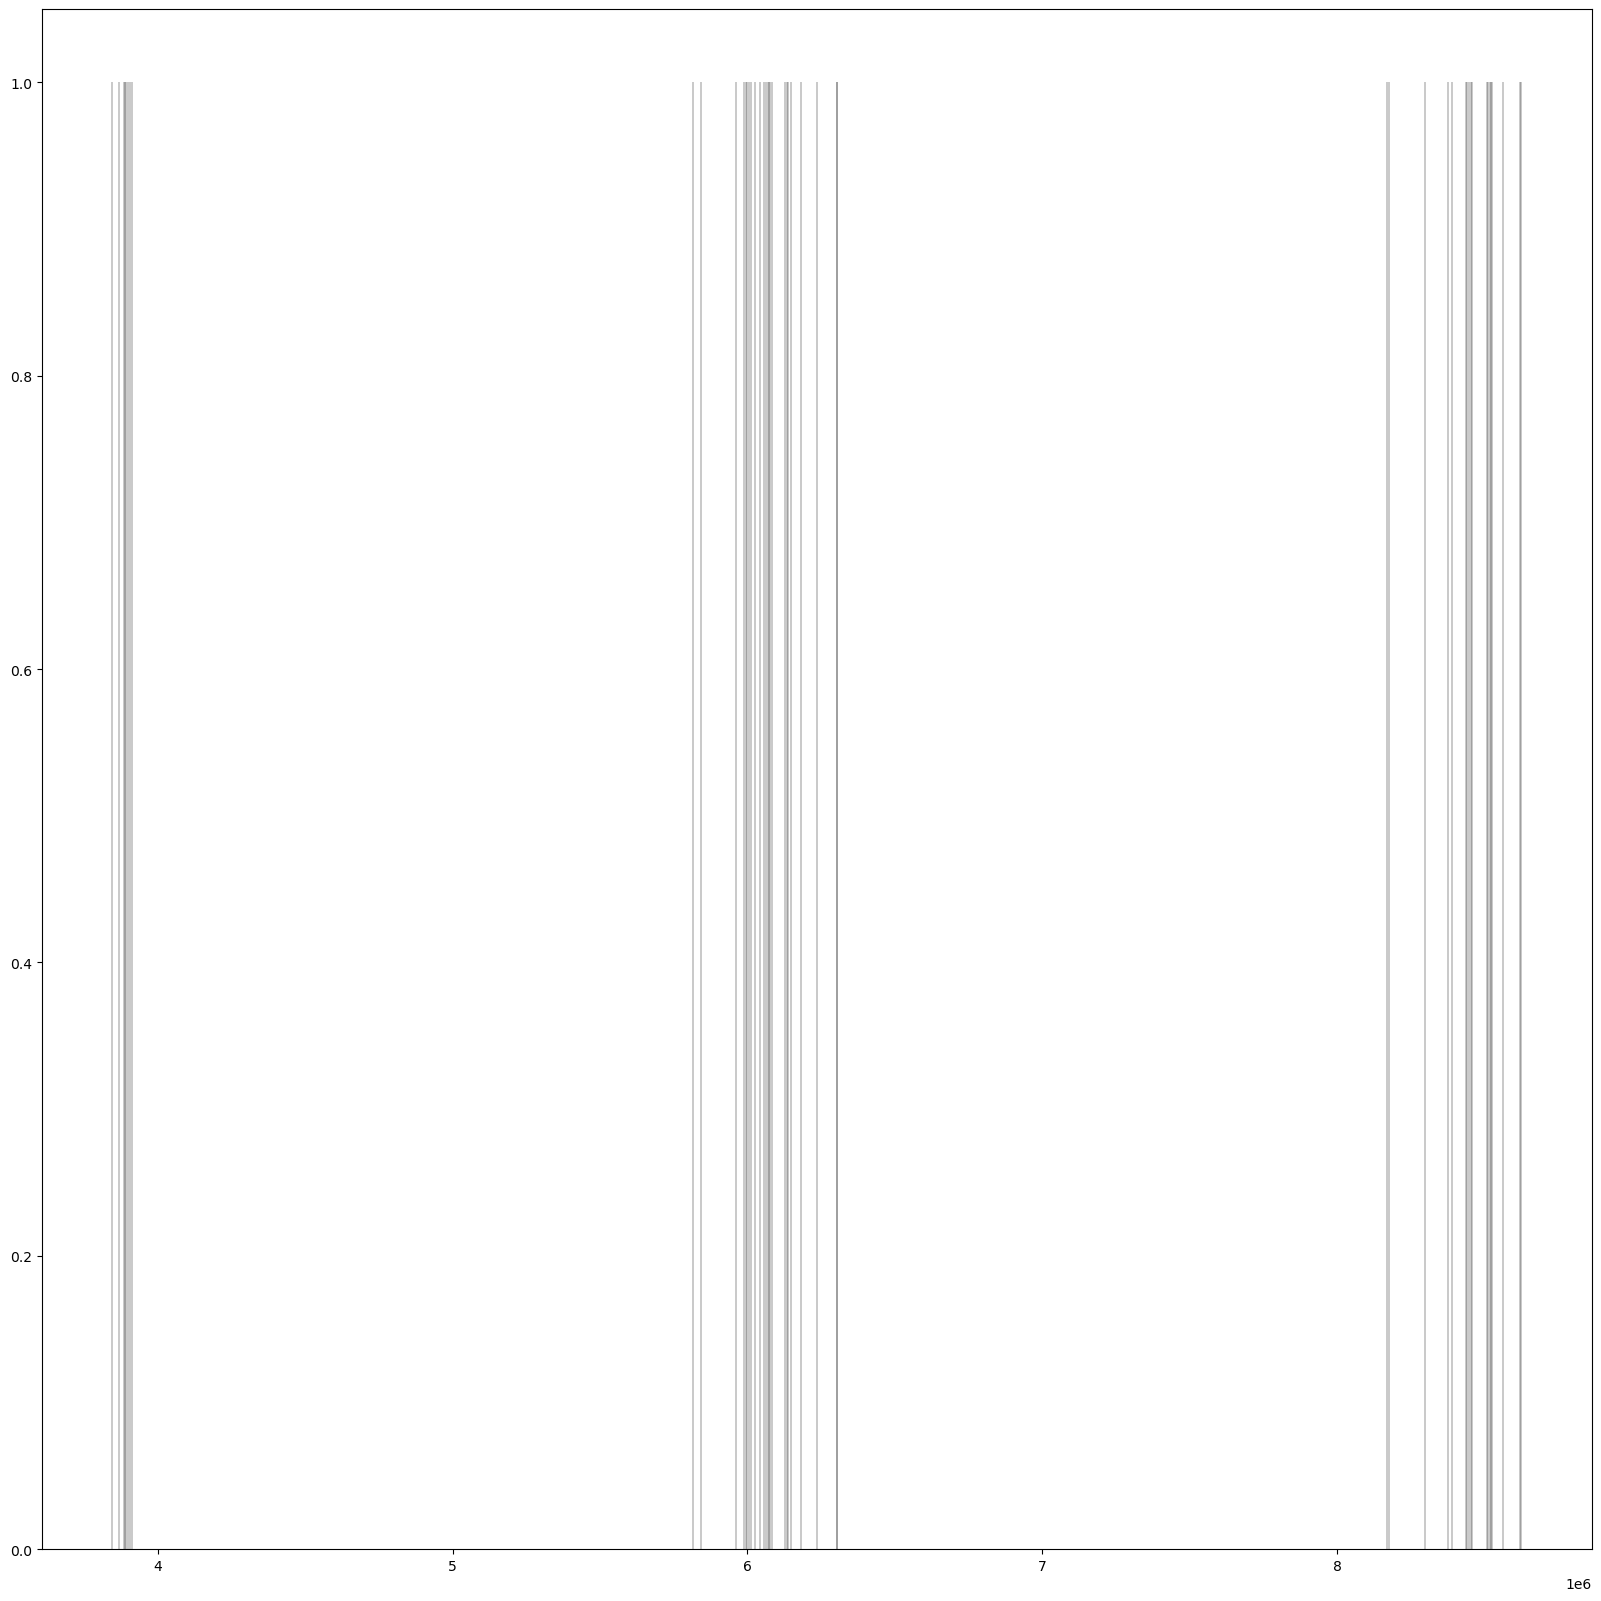

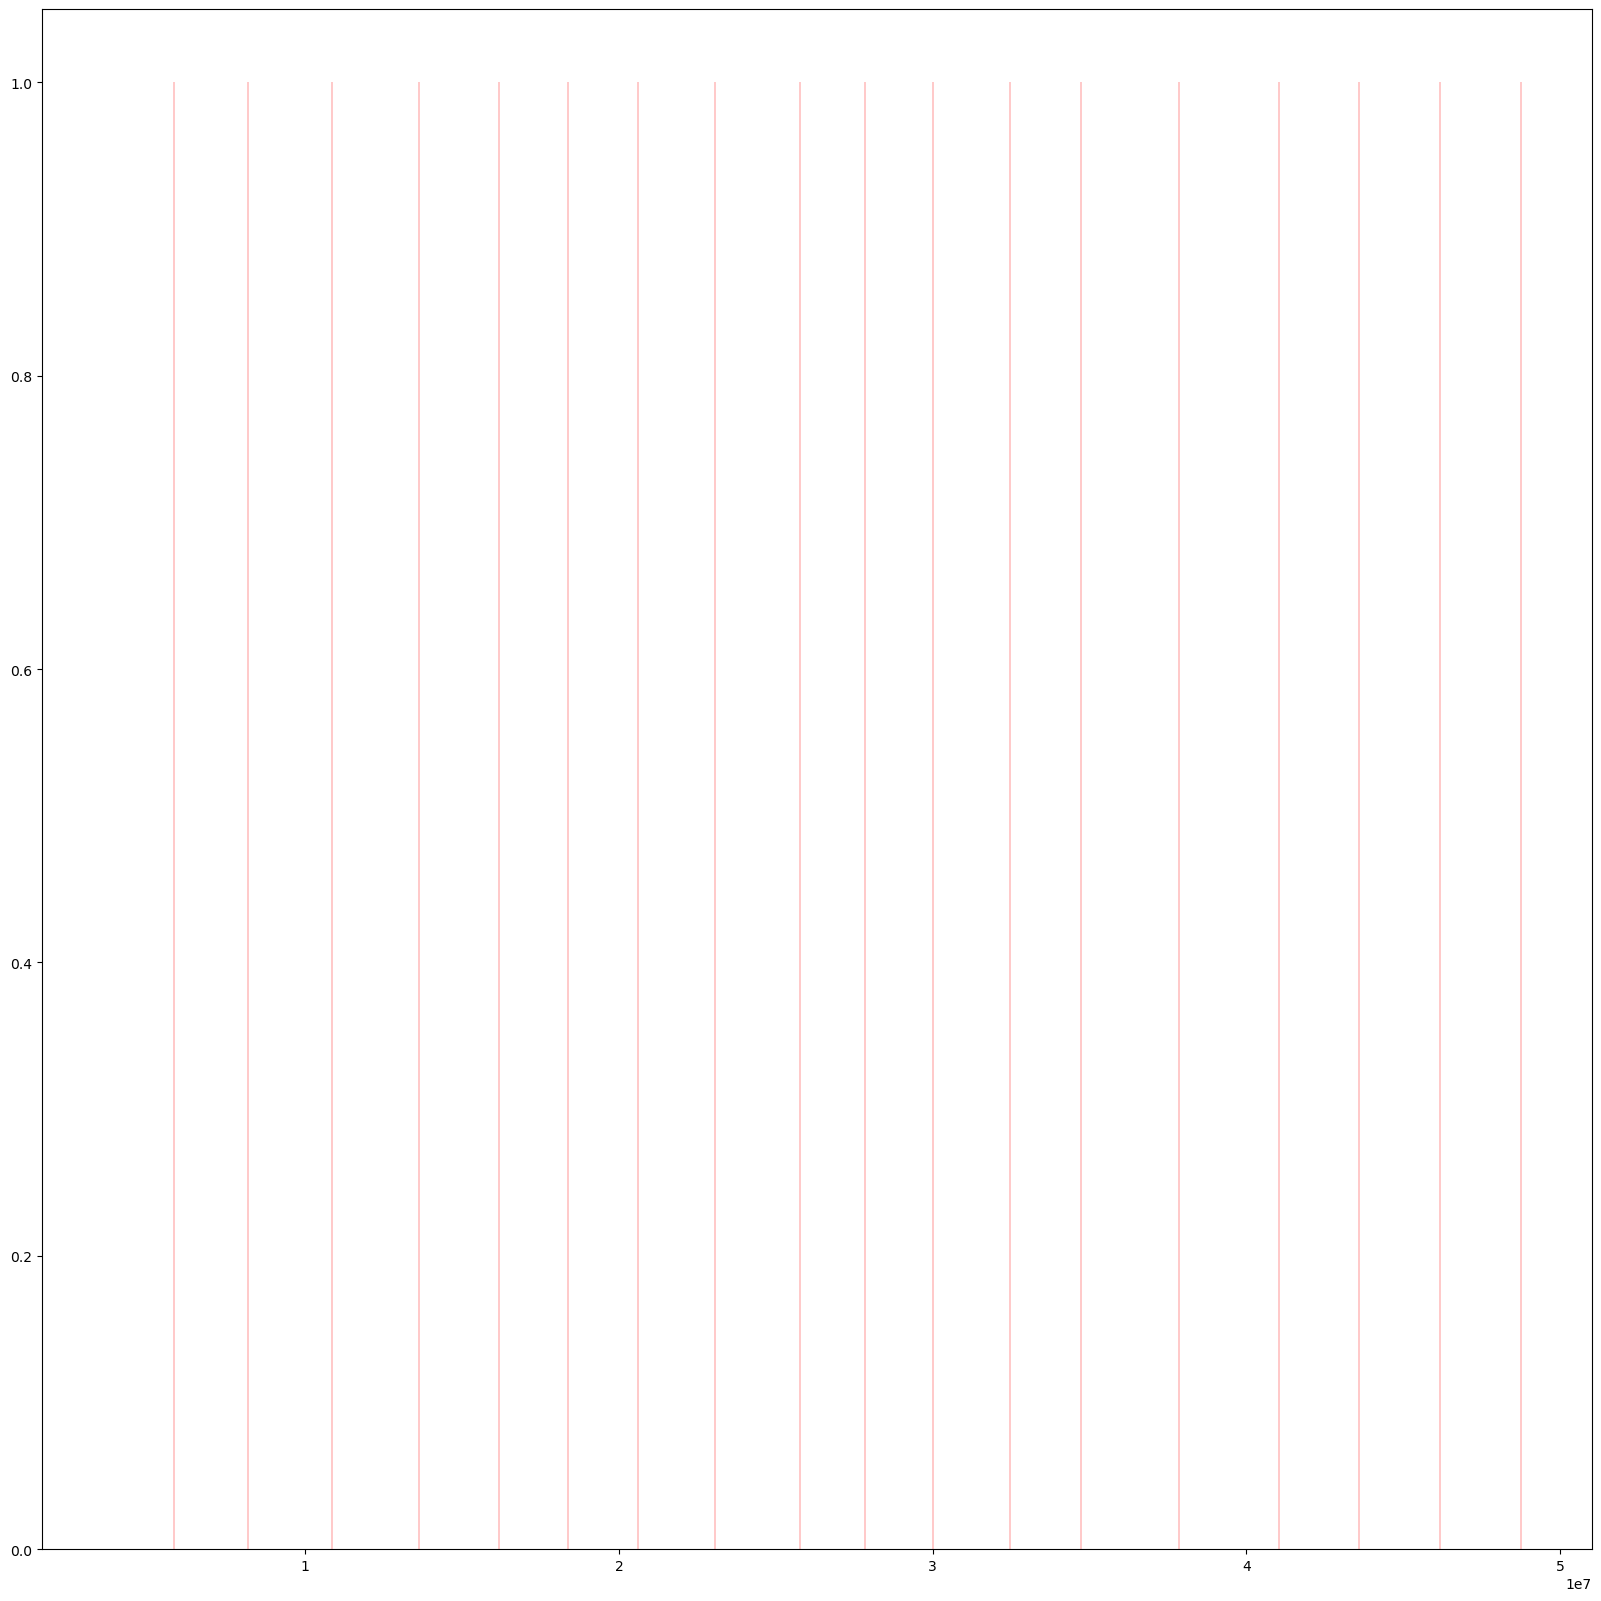

In [339]:

plt.figure(figsize=(20, 20))
x = format_din_for_plotting(din1)
plt.bar(x[0][0:100], x[1][0:100], color='black', edgecolor='black', linewidth=0.3)
plt.show()

plt.figure(figsize=(20, 20))
y = format_din_for_plotting(dout4)
plt.bar(y[0][0:100], y[1][0:100], color='red', edgecolor='red', linewidth=0.3)
plt.show()

# y = format_din_for_plotting(dout4)
# plt.plot(np.array(y[0]), np.array(y[1]))
# plt.show()


# pop = [22,55,62,45,21,22,34,42,42,4,2,8]
# bins = [1,10,20,30,40,50]
# pyplot.hist(pop, bins, rwidth=0.6)


In [ ]:
x = get_accuracy(din1, dout4)
x

In [ ]:
# =======

In [193]:
##################### function ###########################3
ptp_times = []
def convert_trodes_time_to_ptp(trodes_times: None):
    for trodes_time in trodes_times:
        for ptp_time in time['data']:
            if trodes_time == ptp_time[0]:
                ptp_times.append(ptp_time[1])
                break
    return ptp_times

In [113]:
din1_x = []
din1_y = []
for data in din1['data']:
    din1_x.append(data[0])
    din1_y.append(data[1])

In [163]:
dout1_x = []
dout1_y = []
for data in dout4['data']:
    dout1_x.append(data[0])
    dout1_y.append(data[1])

In [161]:
def test_plot(x,y):
    # x = np.linspace(0,5,10)
    # y = np.array([1,0, 0, 0 , 0, 1, 1, 1,0,1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.step(x,y,color='r')
    #ax.step(x,y+2,color='g')
#ax.set_ylim([-2,9])
#ax.set_xlim([-1,6])
    ax.legend()

    ax.draw()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: draw_wrapper() missing 1 required positional argument: 'renderer'

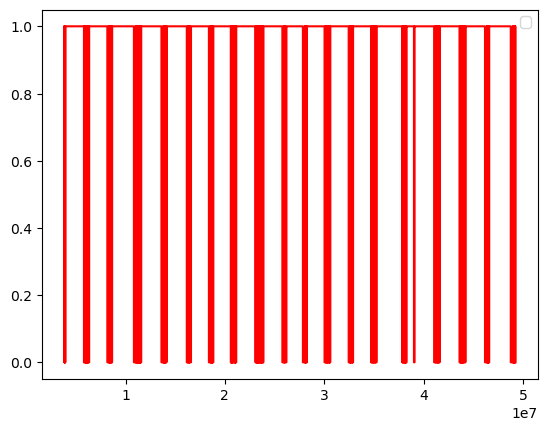

In [171]:
test_plot(din1_x, din1_y)

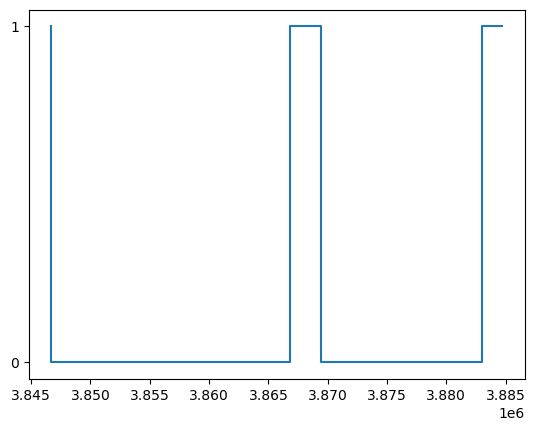

In [160]:
import numpy as np
import matplotlib.pyplot as plt

data = [1, 0, 0, 1, 1, 0, 1, 0]
xs = np.repeat(range(len(data)), 2)
ys = np.repeat(data, 2)
xs = xs[1:]
ys = ys[:-1]
xs = np.append(xs,xs[-1] + 1)
ys = np.append(ys, ys[-1])

ys = np.array([1,0,1,0,1,1,0,1,1])
xs = np.array([0,1,2,3,4,5,6,7,8])



plt.yticks([0,1])
#plt.step(din1_x, din1_y)
#plt.scatter(din1_x[:15], din1_y[:15])
plt.step(din1_x[:5], din1_y[:5])


In [169]:
time_of_data_change = time['data'].tolist()

In [194]:
convert_trodes_time_to_ptp(din1_x[:10])

[1685573333351446152,
 1685573334023404348,
 1685573334108705709,
 1685573334562306970,
 1685573334618414044,
 1685573334627639748,
 1685573334778121401,
 1685573334805365351,
 1685573334901063448,
 1685573335004112169]

In [184]:
din1_y[:15]

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

In [201]:
dout1_x[:15]
#tt = convert_trodes_time_to_ptp(dout1_x[:15])
#print (tt if len(tt) > 0 else 'Empty')

[3846688,
 5816554,
 5825529,
 8168307,
 8177295,
 10843034,
 10852006,
 13610944,
 13619927,
 16163296,
 16172270,
 18386951,
 18395936,
 20592126,
 20601123]

In [186]:
print(dout1_y[:15])

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [179]:
ptp_times = []
def convert_trodes_time_to_ptp(trodes_times):
    for trodes_time in trodes_times:
        for ptp_time in time['data']:
            if trodes_time == ptp_time[0]:
                ptp_times.append(ptp_time[1])
                break
    return ptp_times

In [189]:
convert_trodes_time_to_ptp(din1_x[:8])

[1685573333351446152,
 1685573334023404348,
 1685573334108705709,
 1685573334562306970,
 1685573334618414044,
 1685573334627639748,
 1685573334778121401,
 1685573334805365351]

In [ ]:
tt = convert_trodes_time_to_ptp(dout4['data'][:8])
tt
#convert_trodes_time_to_ptp(din1_x[:8])

In [ ]:
time['data'][:1000]

In [213]:
dout4['data']

array([( 3846688, 0), ( 5816554, 1), ( 5825529, 0), ( 8168307, 1),
       ( 8177295, 0), (10843034, 1), (10852006, 0), (13610944, 1),
       (13619927, 0), (16163296, 1), (16172270, 0), (18386951, 1),
       (18395936, 0), (20592126, 1), (20601123, 0), (23072398, 1),
       (23081377, 0), (25780038, 1), (25789029, 0), (27845737, 1),
       (27854717, 0), (30023167, 1), (30032154, 0), (32452620, 1),
       (32461618, 0), (34716405, 1), (34725394, 0), (37860524, 1),
       (37869511, 0), (41050178, 1), (41059169, 0), (43604024, 1),
       (43613012, 0), (46167867, 1), (46176873, 0), (48761211, 1),
       (48770197, 0)], dtype=[('time', '<u4'), ('state', 'u1')])

In [328]:
time['data']

array([( 4932631, 1685570658686448628), ( 4932632, 1685570658686498426),
       ( 4932633, 1685570658686508889), ...,
       (49944681, 1685572159097939892), (49944682, 1685572159097955456),
       (49944683, 1685572159097988851)],
      dtype=[('time', '<u4'), ('systime', '<i8')])

In [ ]:
#expand_din_to_get_all_times(din1, time)
#din1['data']
din1

In [ ]:
dout6

In [ ]:
(dout6)

In [ ]:
x = parseFields(dout6['fields'])
len(x)

In [ ]:
dout4

In [ ]:
(time)

In [237]:
din2_time_ptp

[1685573333351446152,
 1685573342622823198,
 1685573342714501483,
 1685573342748409186,
 1685573342750418781,
 1685573342809128356,
 1685573343036053491,
 1685573343071764347,
 1685573343592107181,
 1685573343637484697]